<a href="https://colab.research.google.com/github/kristenvonbecker/sql_projects/blob/main/Intro_to_SQLite/Intro_SQLite.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MMA Bootcamp - Intro to SQL

## 1. Preparation

We start by setting up a connection to our sample database, Northwind DB.

In [1]:
# download Northwind SQLite DB
!wget https://tdmdal.github.io/mma-sql-2021/data/northwind.sqlite3

--2024-02-09 12:24:52--  https://tdmdal.github.io/mma-sql-2021/data/northwind.sqlite3
Resolving tdmdal.github.io (tdmdal.github.io)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to tdmdal.github.io (tdmdal.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 804864 (786K) [application/octet-stream]
Saving to: ‘northwind.sqlite3’

northwind.sqlite3   100%[===================>] 786.00K  --.-KB/s    in 0.03s   

2024-02-09 12:24:52 (24.2 MB/s) - ‘northwind.sqlite3’ saved [804864/804864]



In [2]:
# load the SQL magic extension
# https://github.com/catherinedevlin/ipython-sql
# this extension allows us to connect to DBs and issue SQL command
%load_ext sql

# now we can use the magic extension to connect to our SQLite DB
# use %sql to write an inline SQL command
# use %%sql to write SQL commands in a cell
%sql sqlite:///northwind.sqlite3

After connecting to the Northwind DB, let's first check what database engine we are using.

In [3]:
%%sql
SELECT sqlite_version();

 * sqlite:///northwind.sqlite3
Done.


sqlite_version()
3.37.2


We are using [SQLite 3](https://www.sqlite.org/index.html). It's a small and fast Relational Database engine. SQLite DB is self-contained: one database is just a file. Believe it or not, SQLite is the most used DB engine in the world. It's built into millions of mobile phones (e.g. Android or iOS phones) and it's used by many popular apps to store data.  

## 2. A quick look at Northwind DB

### How many tables does this DB have?

A database may contain many tables. Let's see how many tables we have in the Northwind DB.

Every SQLite database has a special table called `sqlite_master`. It contains a master listing of all database objects (tables, indexes, etc.) in the database and the SQL used to create each object. We can query this table to find out how many tables (excluding `sqlite_master`) we have in our Northwind DB.

We will use SQL keywords `SELECT...FROM...WHERE`. Don't worry about them for now. We will soon learn those keywords.

In [4]:
%%sql
SELECT name FROM sqlite_master WHERE type='table' AND name NOT LIKE 'sqlite_%';

 * sqlite:///northwind.sqlite3
Done.


name
Suppliers
Shippers
Employees
Customers
Orders
Categories
Products
OrderDetails


Note that special tables in SQLite start with `sqlite_`. Those are reserved tables for SQLite engine system use. Above we filtered out those tables. In most cases, we shouldn't touch those special tables.

### How does the Categories table look like?

A table is made up of one or more columns/fields. Let's take a look a the Categories table (column names, types, etc.).

In [169]:
%sql PRAGMA table_info([Categories]);

 * sqlite:///northwind.sqlite3
Done.


cid,name,type,notnull,dflt_value,pk
0,CategoryID,INTEGER,1,None,1
1,CategoryName,nvarchar(15),1,None,0
2,Description,ntext,0,None,0
3,Picture,image,0,None,0


### How about the relationships between the tables?

We present the relationships between the tables using an Entity Relationship (ER) diagram.

<img src="https://tdmdal.github.io/mma-sql-2021/images/NW_ER.png" alt="ER Diagram" width="836" height="605" />

In the above ER diagram, the tiny vertical key icon indicates a column is a primary key. A primary key is a column (or set of columns) whose values uniquely identify every row in a table. For example, `OrderID` is the primary key in the `Orders` table, and `OrderID` and `ProductID` (combined) is the primary key in the `OrderDetails` table.

The relationship icon (a line with a horizontal key at one end and an infinite symbol at the other end) indicates a foreign key constraint and a one-to-many relationship. A foreign key is a column (or set of columns) in one table whose values uniquely identify a row of another table or the same table. A foreign key mostly refers to a primary key in another table. A foreign key constraint requires that the constrained column contain only values from the primary key column of the other table. For example `CustomerID` in the `Orders` table is a foreign key that refers to the `CustomerID` primary key in the `Customers` table, and it can only contain values that exist in the `CustomerID` column of the `Customers` table.

In addition, it happens that every foreign key constraint in the Northwind DB establishes a one-to-many relationship, i.e. a row from one table can have multiple matching rows in another table. For example, one row from the `Customers` table can match multiple rows in the `Orders` table (via `CustomerID`). This makes sense as one customer can place more than one orders. (Another common relationship a foreign key constraint can establish is the one-to-one relationship.)

|logo|meaning|
|:------:|:------:|
|![key logo](https://tdmdal.github.io/mma-sql-2021/images/key_vertical.png "key logo")|primary key|
|![foreign key constraint](https://tdmdal.github.io/mma-sql-2021/images/relationship.png "foreign key constraint")|one-to-many foreign key contraint|

**Question**: Why do we need foreign key constraints? (Discussion)

You can find out relationships between tables by querying the `sqlite_master` table. See the code below.

Of course, querying the `sqlite_master` table to find out relationships between tables is specific to SQLite. We would do it differently if we use other database management systems. For example, if we use MySQL system, we would query the `key_column_usage` table in the `information_schema` DB. See this stackoverflow [question](https://stackoverflow.com/questions/20855065/how-to-find-all-the-relations-between-all-mysql-tables).

Alternatively, some SQL client tools can generate ER diagram for you. The above diagram is generated by SQL Server Management Studio (SSMS). The Northwind DB is a sample DB originally shipped with Microsoft SQL Server.

In [6]:
%%sql
-- find out relationships between tables using SQL command
SELECT sql
FROM sqlite_master
WHERE name = "Orders"

 * sqlite:///northwind.sqlite3
Done.


sql
"CREATE TABLE [Orders] ( [OrderID] INTEGER PRIMARY KEY AUTOINCREMENT NOT NULL, [CustomerID] nchar(5) NOT NULL COLLATE NOCASE, [EmployeeID] int NULL, [OrderDate] datetime NULL, [RequiredDate] datetime NULL, [ShippedDate] datetime NULL, [ShipVia] int NULL, [Freight] money DEFAULT 0 NULL, [ShipName] nvarchar(40) NULL COLLATE NOCASE, [ShipAddress] nvarchar(60) NULL COLLATE NOCASE, [ShipCity] nvarchar(15) NULL COLLATE NOCASE, [ShipRegion] nvarchar(15) NULL COLLATE NOCASE, [ShipPostalCode] nvarchar(10) NULL COLLATE NOCASE, [ShipCountry] nvarchar(15) NULL COLLATE NOCASE, CONSTRAINT [FK_Orders_Customers] FOREIGN KEY ([CustomerID]) REFERENCES [Customers] ([CustomerID]) ON DELETE NO ACTION ON UPDATE NO ACTION, CONSTRAINT [FK_Orders_Employees] FOREIGN KEY ([EmployeeID]) REFERENCES [Employees] ([EmployeeID]) ON DELETE NO ACTION ON UPDATE NO ACTION, CONSTRAINT [FK_Orders_Shippers] FOREIGN KEY ([ShipVia]) REFERENCES [Shippers] ([ShipperID]) ON DELETE NO ACTION ON UPDATE NO ACTION)"


## Exercises

**We will work on the problems with a * sign together.** Other problems are left for homework.

## Part 1. Warm-up

We review

1. Retrieve data: `SELECT...FROM...`
2. Sort retrieved data: `SELECT...FROM...ORDER BY...`
3. Filter data: `SELECT...FROM...WHERE...`; `IN`, `NOT`, `LIKE` and `%` wildcard
4. Create calculated fields: mathematical calculations (e.g. +, -, *, /); data manipulation functions (e.g. `DATE()`, `||`)

### Ex1*. Which categories do we have?

Display `CategoryName` and `Description` in the `Categories` table.

In [7]:
%sql SELECT CategoryName, Description FROM Categories;

 * sqlite:///northwind.sqlite3
Done.


CategoryName,Description
Beverages,"Soft drinks, coffees, teas, beers, and ales"
Condiments,"Sweet and savory sauces, relishes, spreads, and seasonings"
Confections,"Desserts, candies, and sweet breads"
Dairy Products,Cheeses
Grains/Cereals,"Breads, crackers, pasta, and cereal"
Meat/Poultry,Prepared meats
Produce,Dried fruit and bean curd
Seafood,Seaweed and fish


In [9]:
# Just curious, what's in the picture column?
result = %sql SELECT Picture FROM Categories;
result.DataFrame().loc[2, 'Picture']

 * sqlite:///northwind.sqlite3
Done.


b"\x15\x1c/\x00\x02\x00\x00\x00\r\x00\x0e\x00\x14\x00!\x00\xff\xff\xff\xffBitmap Image\x00Paint.Picture\x00\x01\x05\x00\x00\x02\x00\x00\x00\x07\x00\x00\x00PBrush\x00\x00\x00\x00\x00\x00\x00\x00\x00\xa0)\x00\x00BM\x98)\x00\x00\x00\x00\x00\x00V\x00\x00\x00(\x00\x00\x00\xac\x00\x00\x00x\x00\x00\x00\x01\x00\x04\x00\x00\x00\x00\x00\x00\x00\x00\x00\x88\x0b\x00\x00\x88\x0b\x00\x00\x08\x00\x00\x00\x08\x00\x00\x00\xff\xff\xff\x00\x00\xff\xff\x00\xff\x00\xff\x00\x00\x00\xff\x00\xff\xff\x00\x00\x00\xff\x00\x00\xff\x00\x00\x00\x00\x00\x00\x00\x1130sW7ww\x04\x00\x00\x00\x00\x00\x00\x00``\x00\x02R\x00\x00\x14\x13\x13\x151\x17\x16\x03pp\x02\x12@\x16\x10u7\x16\x17cu\x065qrQ!q5qp\x1757\x16\x00\x00\x02R\x14\x00 p\x00\x00\x12Cagwww\x1733sqqw777w\x00\x00\x11\x11\x13\x130\x13\x13Wsw\x00\x00\x00\x00\x00\x00\x10\x00\x00P\x04\x00\x063\x11113\x10pPsC\x00@\x00\x00\x03\x07\x07aat3QCVSuqw1qw\x17\x16\x16qp`@vwgugpd%47\x17wwssWS\x17777SSs7\x113\x13\x11\x11\x11\x1111#Ww\x00\x00Cq \x06vwsgwwq\x111S\x13\x11wsw\x07pC\x

<PIL.BmpImagePlugin.BmpImageFile image mode=P size=172x120 at 0x7C1F4B2C7190>


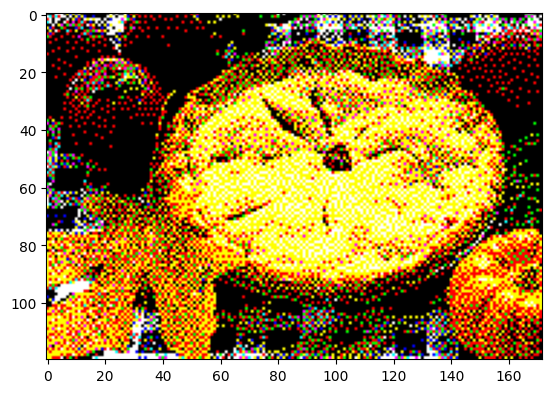

In [12]:
# still curious about the picture column?
# image is actually stored as a blob (Binary Large Object) in SQLite
from matplotlib.pyplot import imshow
from PIL import Image
from io import BytesIO
%matplotlib inline
row = 2
im = Image.open(BytesIO(result.DataFrame().loc[row, 'Picture'][78:])) # cut the first 78 bytes (OLE header)
print(im)
imshow(im)

### Ex2. Which shippers do we have?

In [16]:
%%sql
-- start your code here
SELECT CompanyName FROM Shippers;

 * sqlite:///northwind.sqlite3
Done.


CompanyName
Speedy Express
United Package
Federal Shipping


### Ex3* Find names and hire dates of all US sales representatives

The resulting table should display `FirstName`, `LastName`, `HireDate`, `Title` and `Country`.

In [31]:
%%sql
-- take a look at the Employees table first
-- use LIMIT to limit the rows being displayed
SELECT FirstName, LastName, HireDate, Title, Country
FROM Employees
LIMIT 10

 * sqlite:///northwind.sqlite3
Done.


FirstName,LastName,HireDate,Title,Country
Nancy,Davolio,2010-05-01 00:00:00.000,Sales Representative,USA
Andrew,Fuller,2010-08-14 00:00:00.000,"Vice President, Sales",USA
Janet,Leverling,2010-04-01 00:00:00.000,Sales Representative,USA
Margaret,Peacock,2011-05-03 00:00:00.000,Sales Representative,USA
Steven,Buchanan,2011-10-17 00:00:00.000,Sales Manager,UK
Michael,Suyama,2011-10-17 00:00:00.000,Sales Representative,UK
Robert,King,2012-01-02 00:00:00.000,Sales Representative,UK
Laura,Callahan,2012-03-05 00:00:00.000,Inside Sales Coordinator,USA
Anne,Dodsworth,2012-11-15 00:00:00.000,Sales Representative,UK


In [17]:
%%sql
-- just curious, how many distinct coutries do we have?
SELECT DISTINCT Country
FROM Employees

 * sqlite:///northwind.sqlite3
Done.


Country
USA
UK


In [19]:
%%sql
-- start your code here
SELECT FirstName, LastName, HireDate
FROM Employees
WHERE Title = 'Sales Representative' AND Country = 'USA'
LIMIT 10

 * sqlite:///northwind.sqlite3
Done.


FirstName,LastName,HireDate
Nancy,Davolio,2010-05-01 00:00:00.000
Janet,Leverling,2010-04-01 00:00:00.000
Margaret,Peacock,2011-05-03 00:00:00.000


### Ex4. Find supplier contacts who are *not* marketing managers

Display `supplierID`, `ContactNames` and `ContactTitle` for those whose `ContactTitle` is *not* Marketing Manager.

Hint: `NOT` operator.

In [25]:
%%sql
-- start your code here
SELECT SupplierID, ContactName, ContactTitle
FROM suppliers
WHERE NOT ContactTitle = 'Marketing Manager'
LIMIT 10

 * sqlite:///northwind.sqlite3
Done.


SupplierID,ContactName,ContactTitle
1,Charlotte Cooper,Purchasing Manager
2,Shelley Burke,Order Administrator
3,Regina Murphy,Sales Representative
5,Antonio del Valle Saavedra,Export Administrator
6,Mayumi Ohno,Marketing Representative
8,Peter Wilson,Sales Representative
9,Lars Peterson,Sales Agent
11,Petra Winkler,Sales Manager
12,Martin Bein,International Marketing Mgr.
13,Sven Petersen,Coordinator Foreign Markets


### Ex.5* Find products with "Chef" in its name

Hint: `LIKE` operator and `%` wildcard.

In [31]:
%%sql
-- start your code here
SELECT *
FROM Products
WHERE ProductName LIKE '%Chef%'

 * sqlite:///northwind.sqlite3
Done.


ProductID,ProductName,SupplierID,CategoryID,QuantityPerUnit,UnitPrice,UnitsInStock,UnitsOnOrder,ReorderLevel,Discontinued
4,Chef Anton's Cajun Seasoning,2,2,48 - 6 oz jars,22,53,0,0,0
5,Chef Anton's Gumbo Mix,2,2,36 boxes,21.35,0,0,0,1


### Ex.6 Find all orders shipping to Canada, Mexico or USA.

Hint: `IN` operator.

In [171]:
%%sql
-- start your code here
SELECT *
FROM Orders
WHERE ShipCountry IN ('Canada', 'Mexico', 'USA')
LIMIT 10

 * sqlite:///northwind.sqlite3
Done.


OrderID,CustomerID,EmployeeID,OrderDate,RequiredDate,ShippedDate,ShipVia,Freight,ShipName,ShipAddress,ShipCity,ShipRegion,ShipPostalCode,ShipCountry
10259,CENTC,4,2014-07-18 16:00:00.000,2014-08-15 00:00:00.000,2014-07-25 00:00:00.000,3,3.25,Centro comercial Moctezuma,Sierras de Granada 9993,México D.F.,None,05022,Mexico
10262,RATTC,8,2014-07-22 19:00:00.000,2014-08-19 00:00:00.000,2014-07-25 00:00:00.000,3,48.29,Rattlesnake Canyon Grocery,2817 Milton Dr.,Albuquerque,NM,87110,USA
10269,WHITC,5,2014-07-31 00:00:00.000,2014-08-14 00:00:00.000,2014-08-09 00:00:00.000,1,4.56,White Clover Markets,1029 - 12th Ave. S.,Seattle,WA,98124,USA
10271,SPLIR,6,2014-08-01 05:00:00.000,2014-08-29 00:00:00.000,2014-08-30 00:00:00.000,2,4.54,Split Rail Beer & Ale,P.O. Box 555,Lander,WY,82520,USA
10272,RATTC,6,2014-08-02 03:00:00.000,2014-08-30 00:00:00.000,2014-08-06 00:00:00.000,2,98.03,Rattlesnake Canyon Grocery,2817 Milton Dr.,Albuquerque,NM,87110,USA
10276,TORTU,8,2014-08-08 18:00:00.000,2014-08-22 00:00:00.000,2014-08-14 00:00:00.000,3,13.84,Tortuga Restaurante,Avda. Azteca 123,México D.F.,None,05033,Mexico
10293,TORTU,1,2014-08-29 15:00:00.000,2014-09-26 00:00:00.000,2014-09-11 00:00:00.000,3,21.18,Tortuga Restaurante,Avda. Azteca 123,México D.F.,None,05033,Mexico
10294,RATTC,4,2014-08-30 05:00:00.000,2014-09-27 00:00:00.000,2014-09-05 00:00:00.000,2,147.26,Rattlesnake Canyon Grocery,2817 Milton Dr.,Albuquerque,NM,87110,USA
10304,TORTU,1,2014-09-12 06:00:00.000,2014-10-10 00:00:00.000,2014-09-17 00:00:00.000,2,63.79,Tortuga Restaurante,Avda. Azteca 123,México D.F.,None,05033,Mexico
10305,OLDWO,8,2014-09-13 20:00:00.000,2014-10-11 00:00:00.000,2014-10-09 00:00:00.000,3,257.62,Old World Delicatessen,2743 Bering St.,Anchorage,AK,99508,USA


### Ex.7* Who is the oldest employee?

Display `FirstName`, `LastName`, `Title`, and birth date, ordered by birth date. Show only the date portion of the `BirthDate` column/field (YYYY-MM-DD).

In [38]:
%%sql
-- start your code here
SELECT FirstName, LastName, Title, DATE(BirthDate) AS Birthday
FROM Employees
ORDER BY BirthDate

 * sqlite:///northwind.sqlite3
Done.


FirstName,LastName,Title,Birthday
Margaret,Peacock,Sales Representative,1955-09-19
Nancy,Davolio,Sales Representative,1966-12-08
Andrew,Fuller,"Vice President, Sales",1970-02-19
Steven,Buchanan,Sales Manager,1973-03-04
Laura,Callahan,Inside Sales Coordinator,1976-01-09
Robert,King,Sales Representative,1978-05-29
Michael,Suyama,Sales Representative,1981-07-02
Janet,Leverling,Sales Representative,1981-08-30
Anne,Dodsworth,Sales Representative,1984-01-27


In [57]:
%%sql
SELECT FirstName, LastName, BirthDate, MIN(BirthDate)
FROM Employees

 * sqlite:///northwind.sqlite3
Done.


FirstName,LastName,BirthDate,MIN(BirthDate)
Margaret,Peacock,1955-09-19 00:00:00.000,1955-09-19 00:00:00.000


### EX.8 Show employee full name

Show the `FirstName` and `LastName` columns from the `Employees` table, and then create a new column called `FullName`, showing first name and last name joined together in one column in a format like "DAVOLIO, Nancy".

In [60]:
%%sql
-- start your code here
SELECT UPPER(LastName) || ', ' || FirstName AS FullName
FROM Employees
LIMIT 10

 * sqlite:///northwind.sqlite3
Done.


FullName
"DAVOLIO, Nancy"
"FULLER, Andrew"
"LEVERLING, Janet"
"PEACOCK, Margaret"
"BUCHANAN, Steven"
"SUYAMA, Michael"
"KING, Robert"
"CALLAHAN, Laura"
"DODSWORTH, Anne"


### Ex.9* Which order items have total sales above $12,000.

In the `OrderDetails` table, we have the columns `UnitPrice` and `Quantity`. Create a new column, `TotalPrice`, that multiplies these two (ignore the `Discount` column). Display `OrderID`, `ProductID`, `UnitPrice`, `Quantity` and `TotalPrice`. Order the result first by `ProductID` (ascending) and then by `TotalPrice` (descending).

Note that the question asks about order items (not orders). One order may contain multiple items/products. An order item is identified by the `OrderID` and `ProductID` columns.

In [97]:
%%sql
-- start your code here
SELECT OrderID, ProductID, SUM(UnitPrice * Quantity) AS TotalPrice
FROM OrderDetails
GROUP BY OrderID, ProductID
HAVING TotalPrice > 12000
ORDER BY TotalPrice DESC

 * sqlite:///northwind.sqlite3
Done.


OrderID,ProductID,TotalPrice
10865,38,15810.0
10981,38,15810.0


### Ex.10 Show all products that need reordering

A product need reordering if `UnitsInStock + UnitsOnOrder <= ReorderLevel` and `Discontinued = 0`. In your result, display `ProductID`, `ProductName`, `UnitsInStock`, `UnitsOnOrder`, `ReorderLevel`, and `Discontinued`.

In [79]:
%%sql
-- start your code here
SELECT ProductID, ProductName, UnitsInStock, UnitsOnOrder, ReorderLevel, Discontinued
FROM Products
WHERE UnitsInStock + UnitsOnOrder <= ReorderLevel AND Discontinued = 0

 * sqlite:///northwind.sqlite3
Done.


ProductID,ProductName,UnitsInStock,UnitsOnOrder,ReorderLevel,Discontinued
30,Nord-Ost Matjeshering,10,0,15,0
70,Outback Lager,15,10,30,0


## Part 2. Summarize and Group Data

1. Summarize data using aggregate functions (e.g. `COUNT()`, `MIN()`, `MAX()`, and `AVG()`).
2. Group data and filter groups: `SELECT...FROM...GROUP BY...HAVING...`.
3. `SELECT` clause ordering: `SELECT...FROM...WHERE...GROUP BY...HAVING...ORDER BY...`.
4. Filter data by *subquery*: `SELECT...FROM...WHERE...(SELECT...FROM...)`

### Ex.11* Count total number of order items. What's their minimum, maximum and average price?

Note that the question asks about order items (not orders). One order may contain multiple items/products. An order item is identified by (OrderID + ProductID).

In [108]:
%%sql
-- start your code here
SELECT SUM(Counts) as N, MIN(TotalPrice) as Min, MAX(TotalPrice) as Max, ROUND(AVG(TotalPrice), 2) as Avg
FROM ( SELECT OrderID, ProductID, COUNT(*) AS Counts, SUM(UnitPrice * Quantity) AS TotalPrice FROM OrderDetails GROUP BY OrderID, ProductID )

 * sqlite:///northwind.sqlite3
Done.


N,Min,Max,Avg
2155,4.8,15810.0,628.81


### Ex. 12* How many customers do we have for each contact title.

Order the result by the count of contact titles.

In [83]:
%%sql
-- start your code here
SELECT ContactTitle, COUNT(CustomerID) AS Count
FROM Customers
GROUP BY ContactTitle
ORDER BY Count DESC

 * sqlite:///northwind.sqlite3
Done.


ContactTitle,Count
Sales Representative,17
Owner,17
Marketing Manager,12
Sales Manager,11
Accounting Manager,10
Sales Associate,7
Marketing Assistant,6
Sales Agent,5
Order Administrator,2
Assistant Sales Agent,2


### Ex.13 Find total customers per country and city

In [86]:
%%sql
-- start your code here
SELECT Country, City, COUNT(CustomerID) AS Count
FROM Customers
GROUP BY Country, City

 * sqlite:///northwind.sqlite3
Done.


Country,City,Count
Argentina,Buenos Aires,3
Austria,Graz,1
Austria,Salzburg,1
Belgium,Bruxelles,1
Belgium,Charleroi,1
Brazil,Campinas,1
Brazil,Resende,1
Brazil,Rio de Janeiro,3
Brazil,Sao Paulo,4
Canada,Montréal,1


### Ex.14* Show all orders with values greater than $12,000?

Ignore the `Discount`. Contrast this question to Ex.9.

In [89]:
%%sql
-- start your code here
SELECT OrderID, ROUND(SUM(UnitPrice * Quantity), 2) AS TotalPrice
FROM OrderDetails
GROUP BY OrderID
HAVING TotalPrice > 12000
ORDER BY TotalPrice DESC

 * sqlite:///northwind.sqlite3
Done.


OrderID,TotalPrice
10865,17250.0
11030,16321.9
10981,15810.0
10372,12281.2


### Ex.15* Find top three countries with the highest average freight charges for the last 12 months.

"The last 12 months" is with respect to the last `OrderDate` in the `Orders` table.

In [172]:
%%sql
-- start your code here
-- datetime(): https://www.sqlite.org/lang_datefunc.html

 * sqlite:///northwind.sqlite3
Done.


[]

## Part 3. Join Tables

1. Inner join: `SELECT...FROM...INNER JOIN...ON...`
2. Left join:  `SELECT...FROM...LEFT JOIN...ON...`
3. Other joins.

### Ex.16* Show products and their associated suppliers

Display the `ProductID`, `ProductName`, and the `CompanyName` of the Supplier. Sort by `ProductID`.

We can use the `WHERE` keyword.

In [115]:
%%sql
-- start your code here
SELECT ProductID, ProductName, CompanyName
FROM Products, Suppliers
WHERE Products.SupplierID = Suppliers.SupplierID
ORDER BY ProductID
LIMIT 20

 * sqlite:///northwind.sqlite3
Done.


ProductID,ProductName,CompanyName
1,Chai,Exotic Liquids
2,Chang,Exotic Liquids
3,Aniseed Syrup,Exotic Liquids
4,Chef Anton's Cajun Seasoning,New Orleans Cajun Delights
5,Chef Anton's Gumbo Mix,New Orleans Cajun Delights
6,Grandma's Boysenberry Spread,Grandma Kelly's Homestead
7,Uncle Bob's Organic Dried Pears,Grandma Kelly's Homestead
8,Northwoods Cranberry Sauce,Grandma Kelly's Homestead
9,Mishi Kobe Niku,Tokyo Traders
10,Ikura,Tokyo Traders


We can also use the `(INNER) JOIN` keyword.

In [114]:
%%sql
-- start your code here
SELECT ProductID, ProductName, CompanyName
FROM Products
INNER JOIN Suppliers
ON Products.SupplierID = Suppliers.SupplierID
ORDER BY ProductID
LIMIT 20

 * sqlite:///northwind.sqlite3
Done.


ProductID,ProductName,CompanyName
1,Chai,Exotic Liquids
2,Chang,Exotic Liquids
3,Aniseed Syrup,Exotic Liquids
4,Chef Anton's Cajun Seasoning,New Orleans Cajun Delights
5,Chef Anton's Gumbo Mix,New Orleans Cajun Delights
6,Grandma's Boysenberry Spread,Grandma Kelly's Homestead
7,Uncle Bob's Organic Dried Pears,Grandma Kelly's Homestead
8,Northwoods Cranberry Sauce,Grandma Kelly's Homestead
9,Mishi Kobe Niku,Tokyo Traders
10,Ikura,Tokyo Traders


### Ex.17 Show all orders and shippers with OrderID less than 10255.

Display `OrderID`, `OrderDate` (date only), and `CompanyName` of the Shipper, and sort by `OrderID`. In addition, only display rows with `OrderID < 10255`.

In [121]:
%%sql
-- start your code here
SELECT OrderID, DATE(OrderDate) as OrderDate, CompanyName
FROM Orders
INNER JOIN Shippers
ON Orders.ShipVia = Shippers.ShipperID
WHERE OrderID < 10255
ORDER BY OrderID

 * sqlite:///northwind.sqlite3
Done.


OrderID,OrderDate,CompanyName
10248,2014-07-04,Federal Shipping
10249,2014-07-05,Speedy Express
10250,2014-07-08,United Package
10251,2014-07-08,Speedy Express
10252,2014-07-09,United Package
10253,2014-07-10,United Package
10254,2014-07-11,United Package


### Ex.18* Find total number of products in each category

In your result, display `CategoryName` and total number of product.

In [124]:
%%sql
-- start your code here
SELECT CategoryName, COUNT(*) as ProductCount
FROM Products
INNER JOIN Categories
ON Products.CategoryID = Categories.CategoryID
GROUP BY Products.CategoryID

 * sqlite:///northwind.sqlite3
Done.


CategoryName,ProductCount
Beverages,12
Condiments,12
Confections,13
Dairy Products,10
Grains/Cereals,7
Meat/Poultry,6
Produce,5
Seafood,12


### Ex.19 Show all orders with values greater than $12,000 and are placed in 2016?

In your result, display `OrderID` and total value of the order (ignore `Discount`).

In [140]:
%%sql
-- start your code here
SELECT Orders.OrderID, TotalPrice
FROM Orders
INNER JOIN ( SELECT OrderID, ROUND(SUM(UnitPrice * Quantity), 2) AS TotalPrice FROM OrderDetails GROUP BY OrderID) AS OrderDetails
ON Orders.OrderID = OrderDetails.OrderID
WHERE OrderDetails.TotalPrice > 12000 AND DATE(Orders.ShippedDate) BETWEEN '2016-01-01' AND '2016-12-31'

 * sqlite:///northwind.sqlite3
Done.


OrderID,TotalPrice
10865,17250.0
10981,15810.0
11030,16321.9


### Ex.20* What products has Michael Suyama ever sold?

In your result, display `EmployeeID`, `FirstName`, `LastName`, `ProductID` and `ProductName`.

In [146]:
%%sql
-- start your code here

SELECT DISTINCT Employees.EmployeeID, FirstName, LastName, Products.ProductID, ProductName
FROM Employees
INNER JOIN Orders ON Employees.EmployeeID = Orders.EmployeeID
INNER JOIN OrderDetails ON Orders.OrderID = OrderDetails.OrderID
INNER JOIN Products ON OrderDetails.ProductID = Products.ProductID
WHERE Employees.FirstName = 'Michael' AND Employees.LastName = 'Suyama'

 * sqlite:///northwind.sqlite3
Done.


EmployeeID,FirstName,LastName,ProductID,ProductName
6,Michael,Suyama,14,Tofu
6,Michael,Suyama,51,Manjimup Dried Apples
6,Michael,Suyama,2,Chang
6,Michael,Suyama,41,Jack's New England Clam Chowder
6,Michael,Suyama,33,Geitost
6,Michael,Suyama,20,Sir Rodney's Marmalade
6,Michael,Suyama,31,Gorgonzola Telino
6,Michael,Suyama,72,Mozzarella di Giovanni
6,Michael,Suyama,71,Flotemysost
6,Michael,Suyama,13,Konbu


### Ex.21* Find customers that never placed an order

In [150]:
%%sql
-- start your code here
SELECT Customers.CustomerID, CompanyName, ContactName
FROM Customers
LEFT OUTER JOIN Orders
ON Customers.CustomerID = Orders.CustomerID
WHERE Orders.CustomerID IS NULL

 * sqlite:///northwind.sqlite3
Done.


CustomerID,CompanyName,ContactName
FISSA,FISSA Fabrica Inter. Salchichas S.A.,Diego Roel
PARIS,Paris spécialités,Marie Bertrand


Note that the Jupyter Notebook displays Null as None.

### Ex.22* Find customers who never placed an order from Margaret Peacock (EmployeeID 4)

In [152]:
%%sql
-- start your code here
SELECT Customers.CustomerID, CompanyName, ContactName
FROM Customers
LEFT OUTER JOIN (SELECT * FROM Orders WHERE EmployeeID = 4) AS MargaretOrders
ON Customers.CustomerID = MargaretOrders.CustomerID
WHERE MargaretOrders.CustomerID IS NULL

 * sqlite:///northwind.sqlite3
Done.


CustomerID,CompanyName,ContactName
CONSH,Consolidated Holdings,Elizabeth Brown
DUMON,Du monde entier,Janine Labrune
FISSA,FISSA Fabrica Inter. Salchichas S.A.,Diego Roel
FRANR,France restauration,Carine Schmitt
GROSR,GROSELLA-Restaurante,Manuel Pereira
LAUGB,Laughing Bacchus Wine Cellars,Yoshi Tannamuri
LAZYK,Lazy K Kountry Store,John Steel
NORTS,North/South,Simon Crowther
PARIS,Paris spécialités,Marie Bertrand
PERIC,Pericles Comidas clásicas,Guillermo Fernández


### Ex.23* Find high-value customers - 1

We define high-value customers as those who have made at least 1 order with a total value >= $10,000 (ignore discount). We only consider orders placed in year 2016.

In [164]:
%%sql
-- start your code here
SELECT Customers.CustomerID, TotalPrice
FROM Customers
JOIN Orders ON Customers.CustomerID = Orders.CustomerID
JOIN ( SELECT OrderID, ROUND(SUM(UnitPrice * Quantity), 2) AS TotalPrice FROM OrderDetails GROUP BY OrderID HAVING TotalPrice >= 10000 ) AS OrderDetails
ON Orders.OrderID = OrderDetails.OrderID
WHERE DATE(Orders.ShippedDate) BETWEEN '2016-01-01' AND '2016-12-31'

 * sqlite:///northwind.sqlite3
Done.


CustomerID,TotalPrice
KOENE,11490.7
QUICK,17250.0
RATTC,11380.0
HUNGO,10835.24
HANAR,15810.0
SAVEA,16321.9


### Ex.24 Find high-value customers - 2

This time, we define high-value customers as those who have made total order >= $15,000 (ignore discount). We only consider orders placed in year 2016.

In [168]:
%%sql
-- start your code here
SELECT Customers.CustomerID, SUM(OrderDetails.TotalPrice) AS TotalPrice
FROM Customers
JOIN Orders ON Customers.CustomerID = Orders.CustomerID
JOIN ( SELECT OrderID, ROUND(SUM(UnitPrice * Quantity), 2) AS TotalPrice FROM OrderDetails GROUP BY OrderID ) AS OrderDetails
ON Orders.OrderID = OrderDetails.OrderID
WHERE TotalPrice >= 15000 AND DATE(Orders.ShippedDate) BETWEEN '2016-01-01' AND '2016-12-31'
GROUP BY Orders.CustomerID

 * sqlite:///northwind.sqlite3
Done.


CustomerID,TotalPrice
HANAR,15810.0
QUICK,17250.0
SAVEA,16321.9


## Part 4. Others

If we don't have time to go through all the concepts below, I encourage you to learn them on your own.

1. CTE and temporary table
2. Self-join
3. `CASE` keyword
4. `UNION` keyword

Many SQL implementations support something called Common Table Expression (CTE).

>A CTE is a named temporary result set that exists within the scope of a single statement and that can be referred to later within that statement, possibly multiple times.

CTE is like a subquery, but it's more flexible. In particular, it can be referred to many times in a query, as if we have a temporary table. CTE is created using the `WITH` keyword. Below is a trivial example of CTE.

```
WITH
  cte1 AS (SELECT a, b FROM table1),
  cte2 AS (SELECT c, d FROM table2)
SELECT b, d FROM cte1 JOIN cte2
WHERE cte1.a = cte2.c;

```

You can also use a temporary table to store `SELECT` result. Temporary table can be referred to multiple times in a single session. The syntax to create temporary table and store results from `SELECT` is

```
CREATE TEMPORARY TABLE TableName AS SELECT...
```

### Ex.25* Find the total number of orders fulfilled by the oldest employee (CTE, Subquery, and temporary table)

In [ ]:
%%sql
/* CTE (WITH keyword) */
-- start your code here


In [ ]:
%%sql
/* Subquery */
-- start your code here


In [ ]:
%%sql
/* Temporary Table */
-- start your code here


### Ex.26* For each employee, find what percentage of his/her orders were shipped late?

In your result, display `EmployeeID`, `LastName`, total number of orders, number of late orders, % of late orders (rounding to 2 decimal places).

Define late order as `RequiredData <= ShipppedDate`.

Below are three simpler related questions. You may want to solve them first before you attempt Ex.26 itself.

1. Which orders were shipped late?
2. Which employee has the most late orders?
3. Compare each employee's number of orders and number of late orders.

Note: There are many ways to solve this exercise. One of them is to create temporary tables to help us store intermediate results.

In [ ]:
%%sql
-- 1. Which orders were shipped late?
-- start your code here


In [ ]:
%%sql
-- 2. Which employee has the most late orders?
-- start your code here


In [ ]:
%%sql
-- 3. Compare each employee's number of orders and number of late orders
-- start your code here


In [ ]:
%%sql
-- Solve Ex.26 (Find % of late orders for each employee)
-- start your code here


### Ex.27* Find customers with multiple orders in 5 day period

In [ ]:
%%sql
-- start your code here
-- JOIN keyword


### Ex.28 Group customers by its total order value in 2016 for a sales compaign.

Group customers into four categories, very high (total order in 2016 > 10,000), high (5,000 < total order <= 10,000), medium (1,000 < total order <= 5,000), and low (0 < total order <= 1,000). When calculating total order value, you can ignore discount.

We will learn the `CASE` keyword.

In [ ]:
%%sql
-- step 1
DROP TABLE IF EXISTS TotalOrderAmountTpTable;

CREATE TEMPORARY TABLE TotalOrderAmountTpTable AS
SELECT Customers.CustomerID, CompanyName, SUM(UnitPrice * Quantity) AS TotalOrderAmount
FROM Customers
  JOIN Orders ON Customers.CustomerID = Orders.CustomerID
  JOIN OrderDetails ON Orders.OrderID = OrderDetails.OrderID
WHERE strftime('%Y', OrderDate) = "2016"
GROUP BY Customers.CustomerID, CompanyName
ORDER BY TotalOrderAmount DESC

In [ ]:
%%sql
-- step 2
SELECT CustomerID, CompanyName, totalOrderAmount,
CASE
  WHEN TotalOrderAmount > 0 AND TotalOrderAmount <= 1000 THEN 'Low'
  WHEN TotalOrderAmount > 1000 AND TotalOrderAmount <= 5000 THEN 'Medium'
  WHEN TotalOrderAmount > 5000 AND TotalOrderAmount <= 10000 THEN 'High'
  WHEN TotalOrderAmount > 10000 THEN 'Very High'
END AS CustomerCategory
FROM TotalOrderAmountTpTable
ORDER BY CustomerID;

### Ex. 29 Countries with suppliers and customers

Some Northwind employees are planning a business trip, and they would like to visit as many customers and suppliers as possible. They would like to see a list of all countries and their corresponding total number of customers and total number of suppliers.

#### Method 1. Use intermediate tables.

We will use temporary tables.

In [ ]:
%%sql
-- step 1: count total customers by country
DROP TABLE IF EXISTS TotalCustomersTpTable;

CREATE TEMPORARY TABLE TotalCustomersTpTable AS
SELECT Country, COUNT(CustomerID) AS TotalCustomers
FROM Customers
GROUP BY Country

In [ ]:
%%sql
-- step 2: count total suppliers by country
DROP TABLE IF EXISTS TotalSuppliersTpTable;

CREATE TEMPORARY TABLE TotalSuppliersTpTable AS
SELECT Country, COUNT(SupplierID) AS TotalSuppliers
FROM Suppliers
GROUP BY Country

In [ ]:
%%sql
-- step 3: join two intermediate tables (full outer join using union)
SELECT TotalCustomersTpTable.Country, TotalCustomers, TotalSuppliers
FROM TotalCustomersTpTable
  LEFT JOIN TotalSuppliersTpTable
    ON TotalCustomersTpTable.Country = TotalSuppliersTpTable.Country
UNION
SELECT TotalSuppliersTpTable.Country, TotalCustomers, TotalSuppliers
FROM TotalSuppliersTpTable
  LEFT JOIN TotalCustomersTpTable
    ON TotalCustomersTpTable.Country = TotalSuppliersTpTable.Country
ORDER BY TotalSuppliersTpTable.Country

In [ ]:
%%sql
-- clean up
DROP TABLE TotalCustomersTpTable;
DROP TABLE TotalSuppliersTpTable;

#### Method 2. Use subquery to get a derived table

We find all distinct countries in `Customers` and `Supplier` tables, and combine them to be a derived table `CountriesTable`. This table exists only during the execution of the query. We then `LEFT JOIN` the table to `Customers` and `Supplier` tables, and use `GROUP BY` to obtain the result.

In [ ]:
%%sql
-- Display intermediate result to take a look (debug)
SELECT
  CountriesTable.Country,
  CustomerID,
  SupplierID
FROM
  (SELECT DISTINCT Country FROM Customers
   UNION
   SELECT DISTINCT Country FROM Suppliers
  ) AS CountriesTable -- We have a subquery under the FROM keyword. It gives a derived table, CountriesTable.
  LEFT JOIN Customers ON CountriesTable.Country = Customers.Country
  LEFT JOIN Suppliers ON CountriesTable.Country = Suppliers.Country

In [ ]:
%%sql
-- now, completely solve ex.29
SELECT
  CountriesTable.Country,
  Count(DISTINCT CustomerID) AS TotalCustomers,
  Count(DISTINCT SupplierID) AS TotalSuppliers
FROM
  (SELECT DISTINCT Country FROM Customers
   UNION
   SELECT DISTINCT Country FROM Suppliers
  ) AS CountriesTable -- We have a subquery under the FROM keyword. It gives a derived table, CountriesTable.
  LEFT JOIN Customers ON CountriesTable.Country = Customers.Country
  LEFT JOIN Suppliers ON CountriesTable.Country = Suppliers.Country
GROUP BY CountriesTable.Country
ORDER BY CountriesTable.Country

## Summary

We have covered quite a few basic SQL keywords. They are mostly about getting data from a DB and manipulate the retrieved data. There are much more to SQL. Take a look at this [post](https://stackoverflow.com/questions/2054130/what-is-advanced-sql) to get an idea of what advanced SQL topics are about, and if you are interested, explore them on your own.


## References

Most of the exercises in this notebook are drawn from this [book](https://www.amazon.ca/SQL-Practice-Problems-learn-doing-ebook/dp/B01N41VQFO) by Sylvia Moestl Vasilik. The book is based on Microsoft SQL server and its T-SQL.

Another great SQL book for beginner is [SQL in 10 Minute](https://www.amazon.ca/SQL-Minutes-Sams-Teach-Yourself/dp/0135182794) by Ben Forta.

## Appendix

Examples of various joins shown in the slides.

In [ ]:
# create a new sqlite database
%sql sqlite:///join_playground.sqlite3

In [ ]:
%%sql

-- create left table: table1
DROP TABLE IF EXISTS table1;

CREATE TABLE table1 (
  pk INTEGER NOT NULL,
  t1c1 TEXT NOT NULL
);

INSERT INTO table1
    (pk, t1c1)
VALUES
    (1,"a"),
    (2,"b");

-- create right table: table2
DROP TABLE IF EXISTS table2;

CREATE TABLE table2 (
  fk INTEGER NOT NULL,
  t2c1 TEXT NOT NULL
);

INSERT INTO table2
    (fk, t2c1)
VALUES
    (1,"c"),
    (1,"d"),
    (3,"e");

In [ ]:
%%sql
select * from table1;

In [ ]:
%%sql
select * from table2;

In [ ]:
%%sql
-- inner join
select * from table1 join table2 on table1.pk = table2.fk

In [ ]:
%%sql
-- left join
select *
from table1
  left join table2 on table1.pk = table2.fk

In [ ]:
%%sql
-- left join with exclusion
select *
from table1
  left join table2 on table1.pk = table2.fk
where table2.fk IS NULL

In [ ]:
%%sql
-- right join using LEFT JOIN key word
select *
from table2
  left join table1 on table2.fk = table1.pk

In [ ]:
%%sql
-- right join with exclusion using LEFT JOIN and WHERE key word
select *
from table2
  left join table1 on table2.fk = table1.pk
where table1.pk is NULL

In [ ]:
%%sql
-- fuller outer join
-- it is important to list all the column names (i.e. not using *; can use * if using MySQL)
-- https://stackoverflow.com/questions/53076981/sql-union-doesnt-check-for-matching-column-names-is-it-up-to-me

select pk, t1c1, fk, t2c1
from table1
  left join table2 on table1.pk = table2.fk
union
select pk, t1c1, fk, t2c1
from table2
  left join table1 on table2.fk = table1.pk;

In [ ]:
%%sql
-- full outer join with exclusion
select pk, t1c1, fk, t2c1
from table1
  left join table2 on table1.pk = table2.fk
where table2.fk is NULL
union
select pk, t1c1, fk, t2c1
from table2
  left join table1 on table2.fk = table1.pk
where table1.pk is NULL;